## Basic example of how to bin along-track ICESat-2 sea ice data, as requeated during the hackweek. 

* Notebook author: Alek Petty
* Description: Notebook showing (one way) of binning along-track data to the NSIDC grid
* Input requirements: Demo ATL10 data file
* Date: July 2020


In [23]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')
import cartopy.crs as ccrs
import h5py
import scipy
from astropy.time import Time
import utils as ut
import readers as rd
import pyproj


In [24]:
#Magic function to enable interactive plotting in Jupyter notebook
%matplotlib inline

In [25]:
data_loc='/home/jovyan/tutorial-data/sea-ice/'
fname='ATL10-01_20181115003141_07240101_002_01.h5'
fileT= data_loc+fname

In [26]:
beamStr='gt1r'
dF10 = rd.getATL10data(fileT, beam=beamStr)
dF10.head()

ATL10 file: /home/jovyan/tutorial-data/sea-ice/ATL10-01_20181115003141_07240101_002_01.h5


,freeboard,freeboard_quality,height,ssh_flag,lon,lat,delta_time,deltaTimeRel,height_segment_id,datetime,seg_x
0,0.077381,1,-0.037623,0,-168.648556,73.745906,2.747826e+07,219.501606,969,2018-11-15 00:50:58.225562,8.230003e+06
1,0.070254,1,-0.044749,0,-168.648610,73.746011,2.747826e+07,219.503267,970,2018-11-15 00:50:58.227223,8.230015e+06
2,0.029698,1,-0.085305,0,-168.648625,73.746040,2.747826e+07,219.503734,971,2018-11-15 00:50:58.227690,8.230018e+06
3,0.023347,1,-0.091656,0,-168.648647,73.746084,2.747826e+07,219.504422,972,2018-11-15 00:50:58.228379,8.230023e+06
4,0.000000,1,-0.118993,1,-168.648667,73.746124,2.747826e+07,219.505058,973,2018-11-15 00:50:58.229014,8.230028e+06


In [27]:
def create_grid_nsidc(epsg_string='3411', nx=304, ny=448, leftx=-3837500, dxRes=25000, uppery=5837500, dyRes=25000):
    """ Use pyproj to generate the NSIDC North Polar Stereographic grid covering the given domain (defined by the projection and the corner lat/lons)"""

    crs = pyproj.CRS.from_string("epsg:"+epsg_string)
    p=pyproj.Proj(crs)
    
    print(dxRes, dyRes)

    x=leftx+dxRes*np.indices((ny,nx),np.float32)[1]
    y=uppery-dxRes*np.indices((ny,nx),np.float32)[0]
    lons, lats = p(x, y, inverse=True)
    
    return x, y, lats, lons, p

def create_grid_og(epsg_string='3413', dxRes=25000., lllat=36, llon=-90, urlat=36, urlon=90):
    """ Use pyproj to generate a grid covering the given domain (defined by the projection and the corner lat/lons)"""

    crs = pyproj.CRS.from_string("epsg:"+epsg_string)
    p=pyproj.Proj(crs)
    llcrn=p(llon, lllat)
    urcrn=p(urlon, urlat)

    print(llcrn)
    print(urcrn)

    nx = int((urcrn[0]-llcrn[0])/dxRes)+1
    ny = int((urcrn[1]-llcrn[1])/dxRes)+1
    print(nx, ny)

    x = llcrn[0]+dxRes*np.indices((ny,nx),np.float32)[0] # 1=column indicdes
    y = llcrn[1]+dxRes*np.indices((ny,nx),np.float32)[1] # 0=row indices

    lons, lats = p(x, y, inverse=True)

    return x, y, lats, lons, p


In [28]:
xptsG, yptsG, latG, lonG, proj = create_grid_nsidc()

25000 25000


In [29]:
def bin_data(xpts, ypts, var, xptsG, yptsG, dx):
    """ Bin data using numpy histogram2d
    
    Adapted for the NSIDC grid which has its orgin in the top left corner.

    """
    
    # Need to flip the arrays because the origin is in the top left but the histogram2d function needs x/y increasing.
    xptsG2=np.flipud(xptsG)
    yptsG2=np.flipud(yptsG)
    
    # get bin edges by subtracting half a grid-width and adding on another bin in both directions
    xbins=xptsG2[0]-(dx/2)
    ybins=yptsG2[:, 0]-(dx/2)

    xbins2=np.append(xbins, xbins[-1]+dx)
    ybins2=np.append(ybins, ybins[-1]+dx)
    
    print('binning..')
    #print(xbins2.shape)
    #print(ybins2.shape)
    counts, xedges, yedges = np.histogram2d(xpts, ypts,bins=(xbins2, ybins2))
    z, _, _ = np.histogram2d(xpts, ypts,bins=(xbins2, ybins2), weights=var)
    varG = z / counts
    
    # Need to re-flip the arrays then transpose because of how histogram2d works across columns then rows.
    varG=np.flipud(varG.T)
    counts=np.flipud(counts.T)

    return varG

def bin_data_og(xpts, ypts, var, xptsG, yptsG, dx):
    """ Bin data using numpy histogram 2d
     You can use this one when using the og grid"""

    xbins=xptsG[:,0]-(dx/2)
    ybins=yptsG[0, :]-(dx/2)
    xbins=np.append(xbins, xbins[-1]+dx)
    ybins=np.append(ybins, ybins[-1]+dx)

    counts, xedges, yedges = np.histogram2d(xpts, ypts,bins=(xbins, ybins))
    z, _, _ = np.histogram2d(xpts, ypts,bins=(xbins, ybins), weights=var)
    varG = z / counts
    
    return varG


In [30]:
# Define a projection 
mapProj = pyproj.Proj("+init=EPSG:3411")
x10, y10=mapProj(dF10.lon.values, dF10.lat.values)

varG=bin_data(x10, y10, dF10.freeboard.values, xptsG, yptsG, dx)
print(varG.shape)

binning..
(448, 304)


In [31]:
varG

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

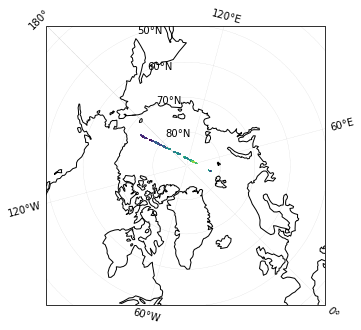

In [32]:
# Plot this gridded data
# Note that we're not using the exact same projection here but a similar built-in North Polar Stereographic projection, just for plotting.
fig=plt.figure(figsize=(5, 6))
# Use the in-built northpolarstereo to vizualize (should somehow use the actual projection)
ax = plt.axes(projection =ccrs.NorthPolarStereo(central_longitude=-45))
cs=ax.pcolormesh(lonG, latG, varG, vmin=0, vmax=0.5,transform=ccrs.PlateCarree(), zorder=2)
ax.coastlines(zorder=3)
ax.gridlines(draw_labels=True,
          linewidth=0.22, color='gray', alpha=0.5, linestyle='--')

ax.set_extent([-179, 179, 50, 90], ccrs.PlateCarree())

In [33]:
# As a sanity check let's plot the raw data too...

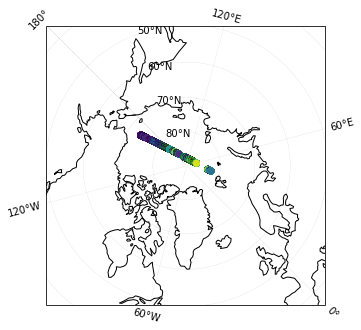

In [34]:
# Plot this gridded data
fig=plt.figure(figsize=(5, 6))
# Use the in-built northpolarstereo to vizualize (should somehow use the actual projection)
ax = plt.axes(projection =ccrs.NorthPolarStereo(central_longitude=-45))
cs=ax.scatter(dF10.lon.values, dF10.lat.values, c=dF10.freeboard.values,vmin=0, vmax=0.5,transform=ccrs.PlateCarree(), zorder=2)
ax.coastlines(zorder=3)
ax.gridlines(draw_labels=True,
          linewidth=0.22, color='gray', alpha=0.5, linestyle='--')

ax.set_extent([-179, 179, 50, 90], ccrs.PlateCarree())